This notebook is for plotting the pharmacophore distributions as histograms, KDE fits of the distributions, and the interpolated fit over the KDE.

In [1]:
import fresco
import importlib
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import KDEpy
from sklearn.neighbors import KernelDensity
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set(rc={"figure.dpi": 150})
sns.set_style('white')

CMAP = plt.get_cmap("tab10")

importlib.reload(fresco)


PHARMACOPHORE_COMBINATIONS = ['Donor-Aromatic',
                              'Aromatic-Acceptor',
                              'Aromatic-Aromatic',
                              'Donor-Donor',
                              'Donor-Acceptor',
                              'Acceptor-Acceptor']


INFO:rdkit:Enabling RDKit 2022.03.1 jupyter extensions


Load saved pickles of pharmacophore distribution and KDEs

In [2]:
fig_dir = '/home/wjm41/ml_physics/frag-pcore-screen/figs/plots'

data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/pickles'

frags = pickle.load(open(data_dir + '/frags_mpro.pickle', 'rb'))

frag_pair_distance_dict = pickle.load(
    open(pickle_dir + '/frag_pair_distance_dict_mpro.pickle', 'rb'))
rand_pair_dicts = pickle.load(
    open(pickle_dir + '/rand_pair_dicts_mpro.pickle', 'rb'))

kde_dict_opt = pickle.load(
    open(pickle_dir + '/kde_dict_opt_mpro.pickle', 'rb'))
rand_kde_dicts = pickle.load(
    open(pickle_dir + '/rand_kde_dicts_mpro.pickle', 'rb'))

frag_2body_dict = pickle.load(
    open(pickle_dir + '/frag_pair_distance_dict_mpro.pickle', 'rb'))

kde_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/pickles'
kdes = {'mpro': 'kde_dict_spl_mpro.pickle',
        'mac1': 'kde_dict_spl_mac1.pickle',
        'dpp11': 'kde_dict_spl_dpp11.pickle'}
kde_dicts = pickle.load(open(f"{kde_dir}/{kdes['mpro']}", 'rb'))


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator KernelDensity from version 0.23.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Compare histogram of pharmacophore distributions against the interpolated KDE fits

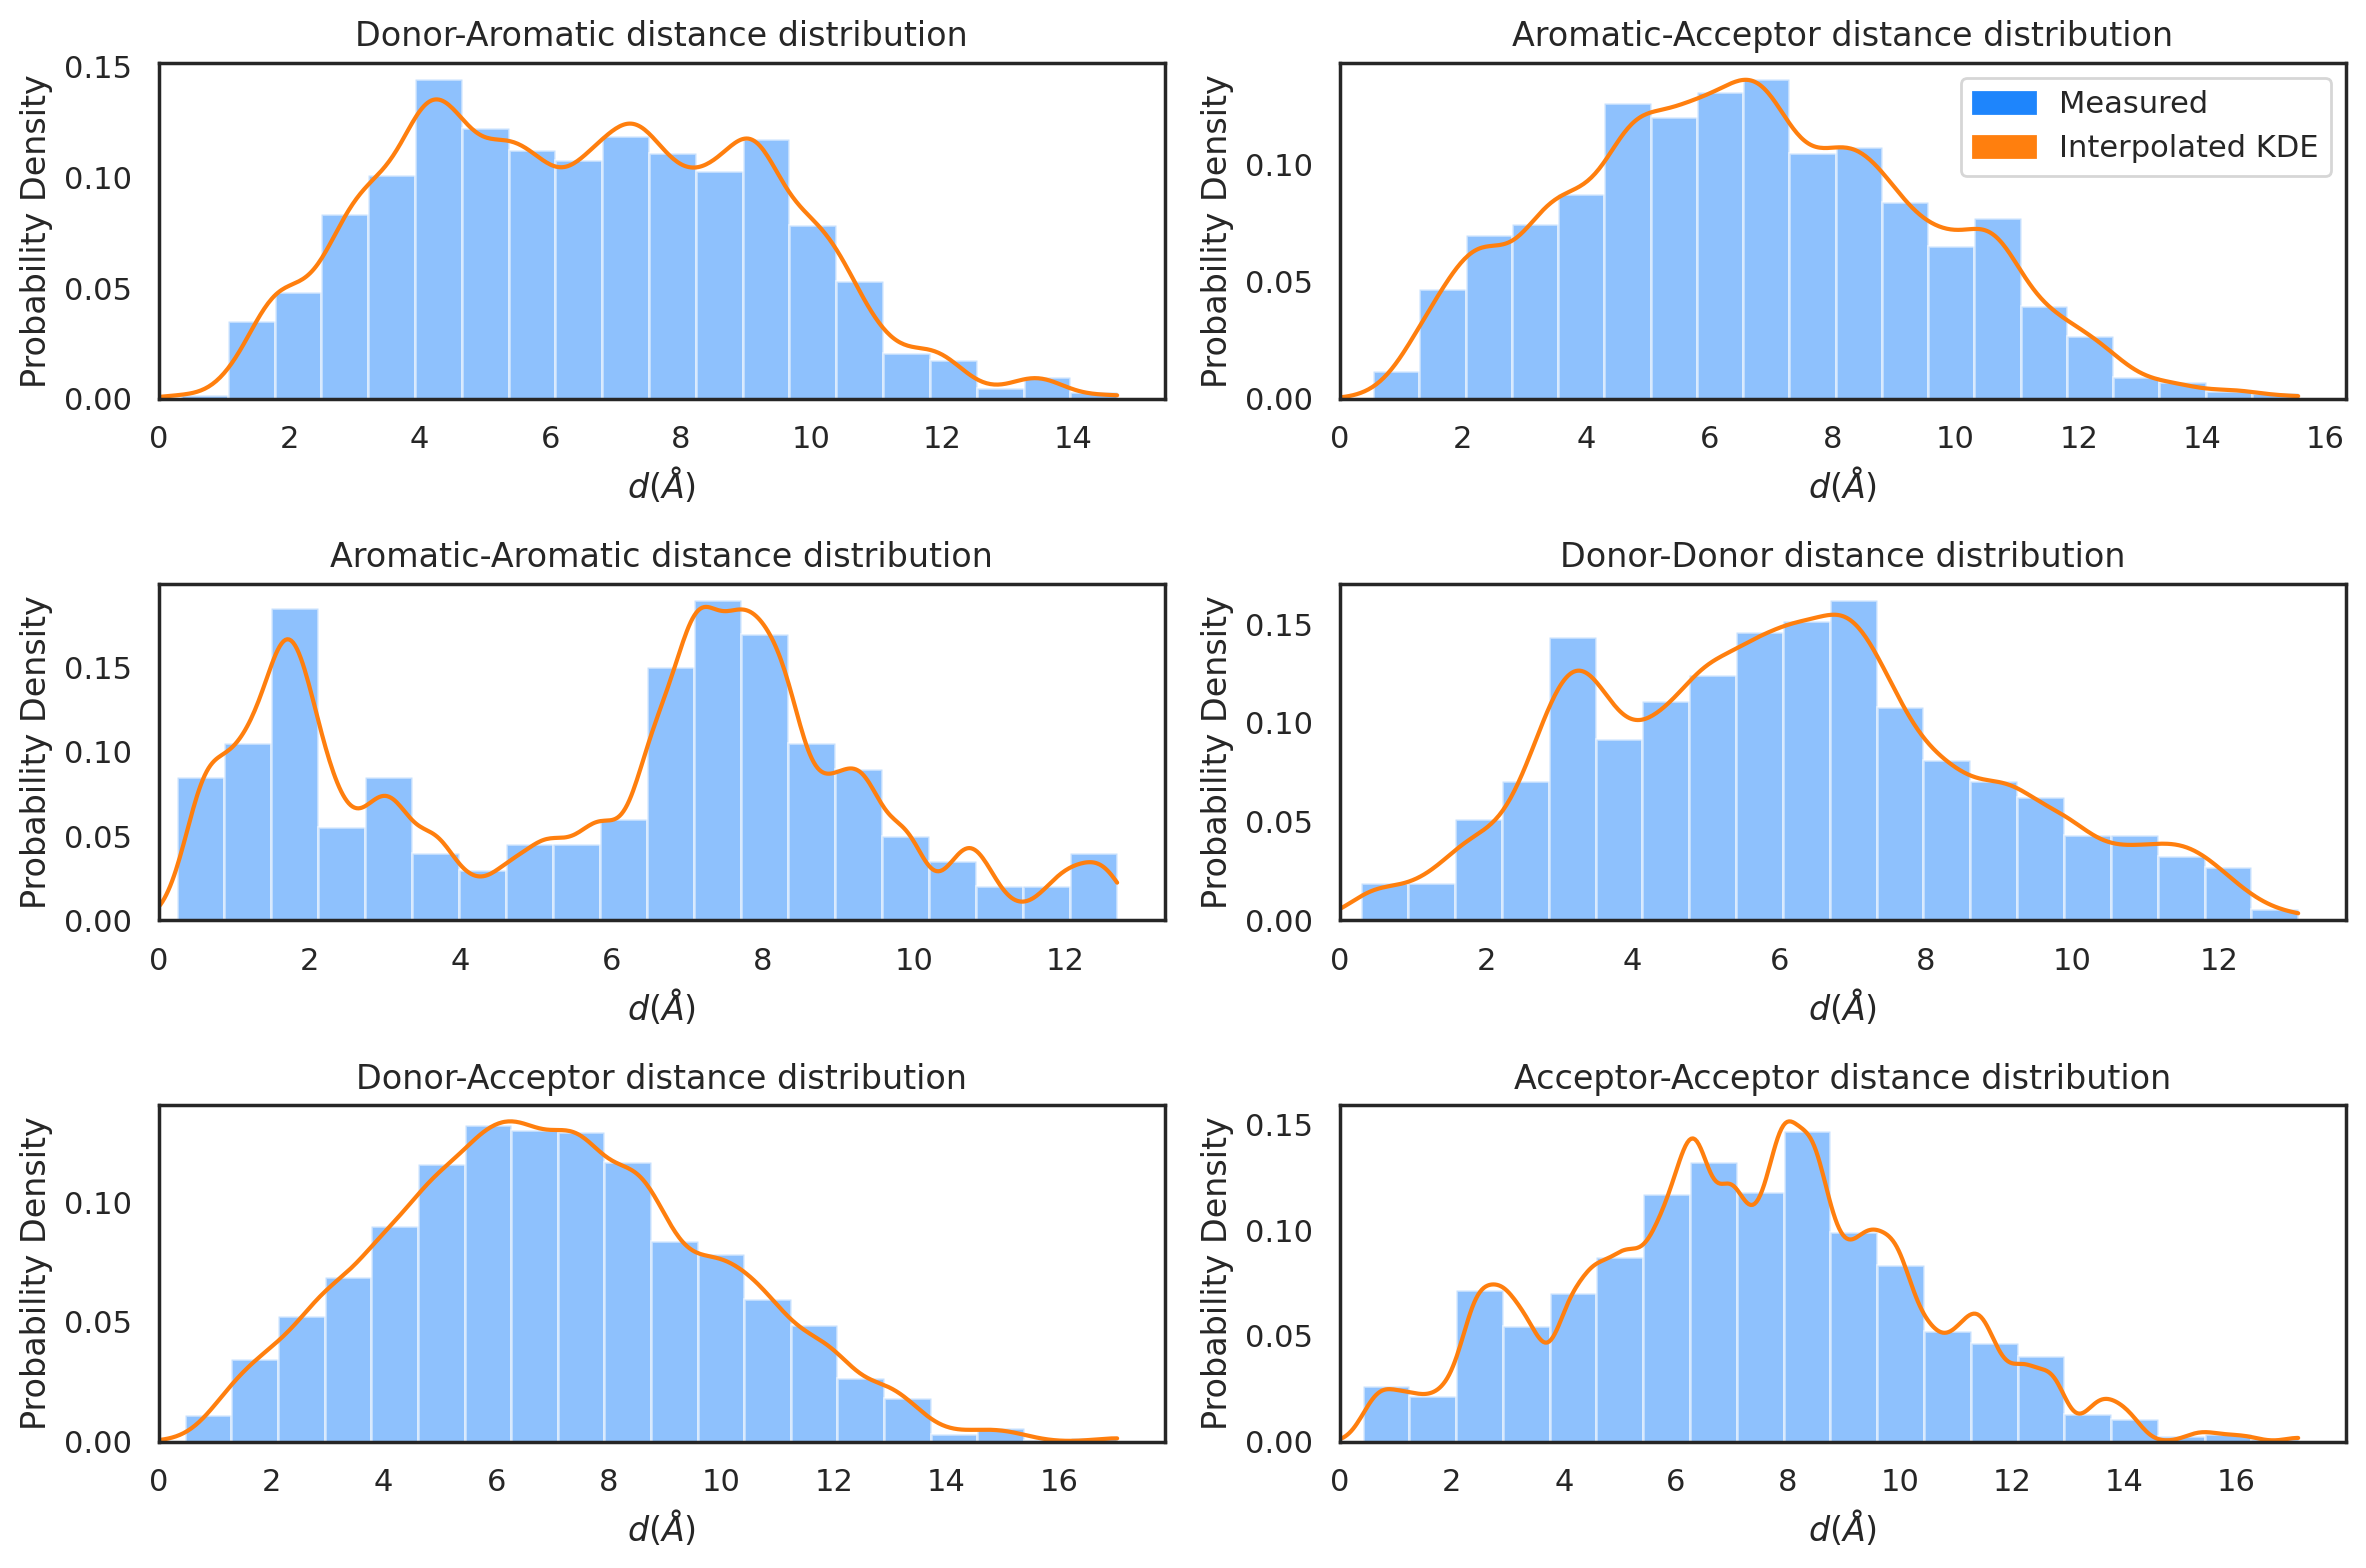

In [3]:
def plot_kdes_against_histogram(kde_dicts, frag_2body_dict, nx=500, n_bins=20):


    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,8), dpi=200)
    axs = axs.reshape(-1)
    for i, pcore_combo in enumerate(PHARMACOPHORE_COMBINATIONS):
        x = np.linspace(0, np.amax(frag_2body_dict[pcore_combo]), nx)
        kde_pair = kde_dicts[pcore_combo]
        axs[i].set_title('{} distance distribution'.format(
            pcore_combo))
        axs[i].hist(frag_2body_dict[pcore_combo], bins=n_bins,
                    alpha=0.5, density=True, color='#1E85FC')
        axs[i].plot(x, np.exp(kde_pair(x)), color=CMAP(1))
        axs[i].set_xlim(left=0)
        axs[i].set_ylabel('Probability Density')
        axs[i].set_xlabel(r'$d (\AA)$')
    legend_elements = [Rectangle((0, 0), 1, 1, color='#1E85FC', label='Measured'),
                    Rectangle((0, 0), 1, 1,  color=CMAP(1), label='Interpolated KDE')]
    axs[1].legend(handles=legend_elements, loc='upper right')
    fig.tight_layout()    
    fig.show()
    return fig

fig_kdes_against_histogram = plot_kdes_against_histogram(
    kde_dicts, frag_2body_dict)
fig_kdes_against_histogram.savefig(f'{fig_dir}/kdes_against_histogram.png')


Compare the histograms against what they would look like if the pharmacophore identities were randomly scrambled

NameError: name 'x' is not defined

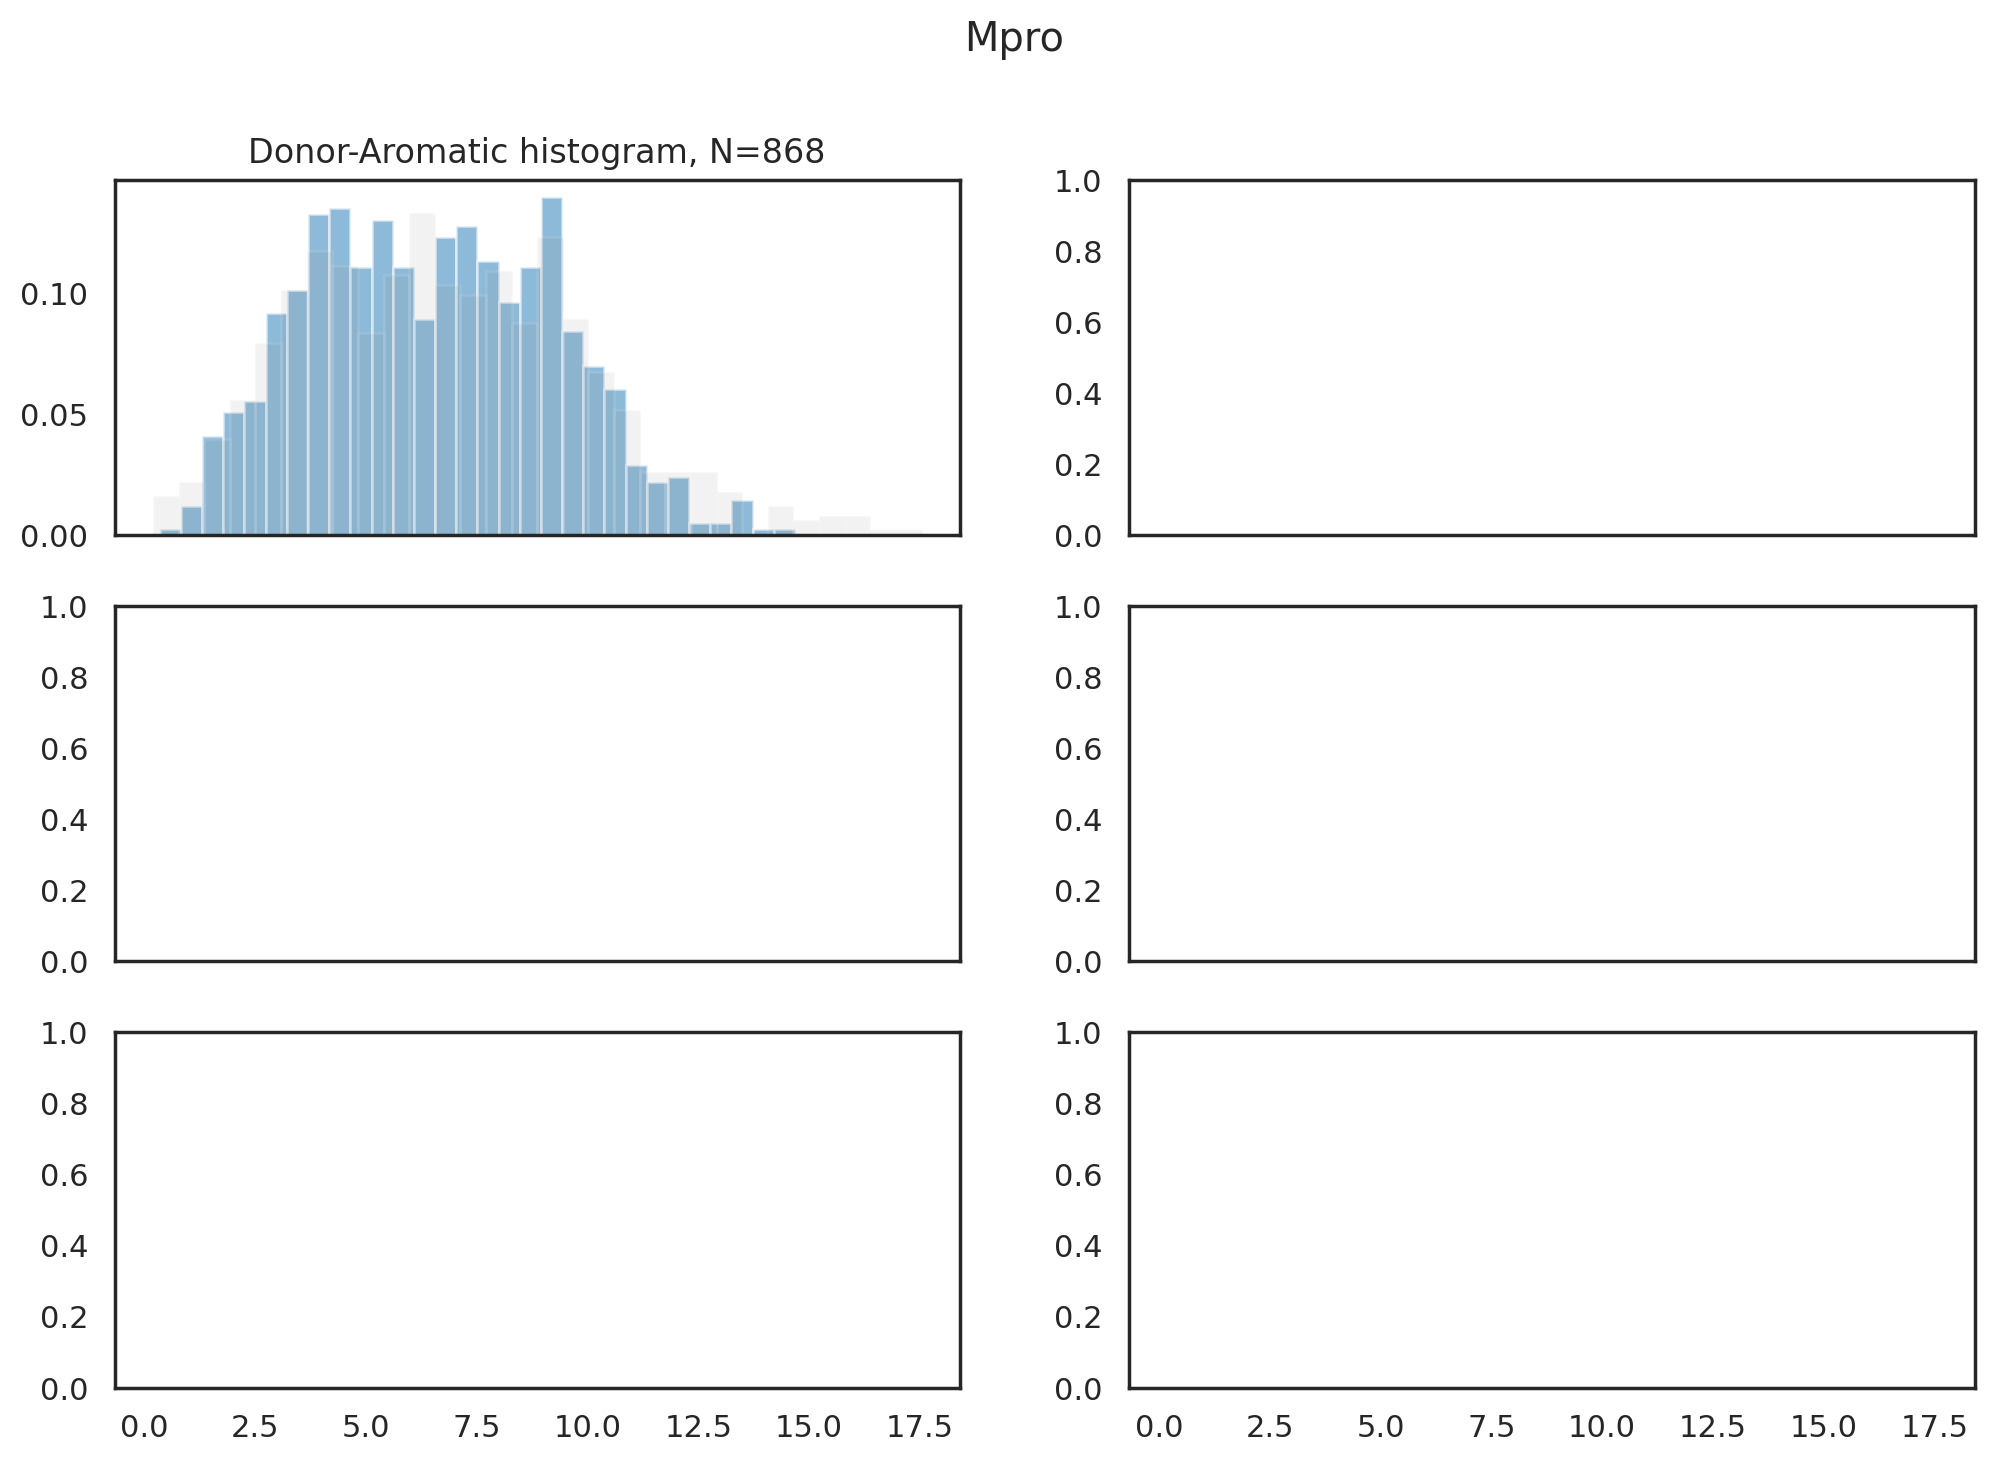

In [4]:
def plot_dists_against_random(frag_2body_dict, rand_kde_dicts, rand_2body_dicts, name, c=0):
    n_bins = 30
    n_rand = 10

    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(
        12, 8), dpi=200)
    fig.suptitle(name)

    axs = axs.reshape(-1)
    for i, pcore_combo in enumerate(PHARMACOPHORE_COMBINATIONS):
        axs[i].set_title('{} histogram, N={}'.format(
            pcore_combo, len(frag_2body_dict[pcore_combo])))
        axs[i].hist(frag_2body_dict[pcore_combo], bins=n_bins,
                    alpha=0.5, density=True, color=CMAP(c))

        for n in range(n_rand):
            axs[i].hist(rand_2body_dicts[n][pcore_combo], bins=30,
                        alpha=0.1, density=True, color='grey')
            kde_rand = rand_kde_dicts[n][pcore_combo]

            rand_dist = kde_rand.score_samples(x.reshape(-1, 1))
            rand_dist = rand_dist.flatten()

    legend_elements = [Rectangle((0, 0), 1, 1, color=CMAP(c), label='Measured'),
                       Rectangle((0, 0), 1, 1,  color='grey', label='Random')]
    axs[0].legend(handles=legend_elements, loc='upper right')
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False,
                    bottom=False, left=False, right=False)
    plt.xlabel('Distance (angstrom)', labelpad=30)
    plt.ylabel('Probability Density', labelpad=30)

    fig.tight_layout()
    fig.show()
    return fig

fig_dists_against_random = plot_dists_against_random(frag_pair_distance_dict, rand_kde_dicts, rand_pair_dicts, name='Mpro', c=0)
fig_dists_against_random.savefig(f'{fig_dir}/dists_against_random.png')

Plot different methods of generating KDEs against each other - the three lines `kdepy`, `sklearn ISJ bw`, and `interpolation` all lie on top of each other.

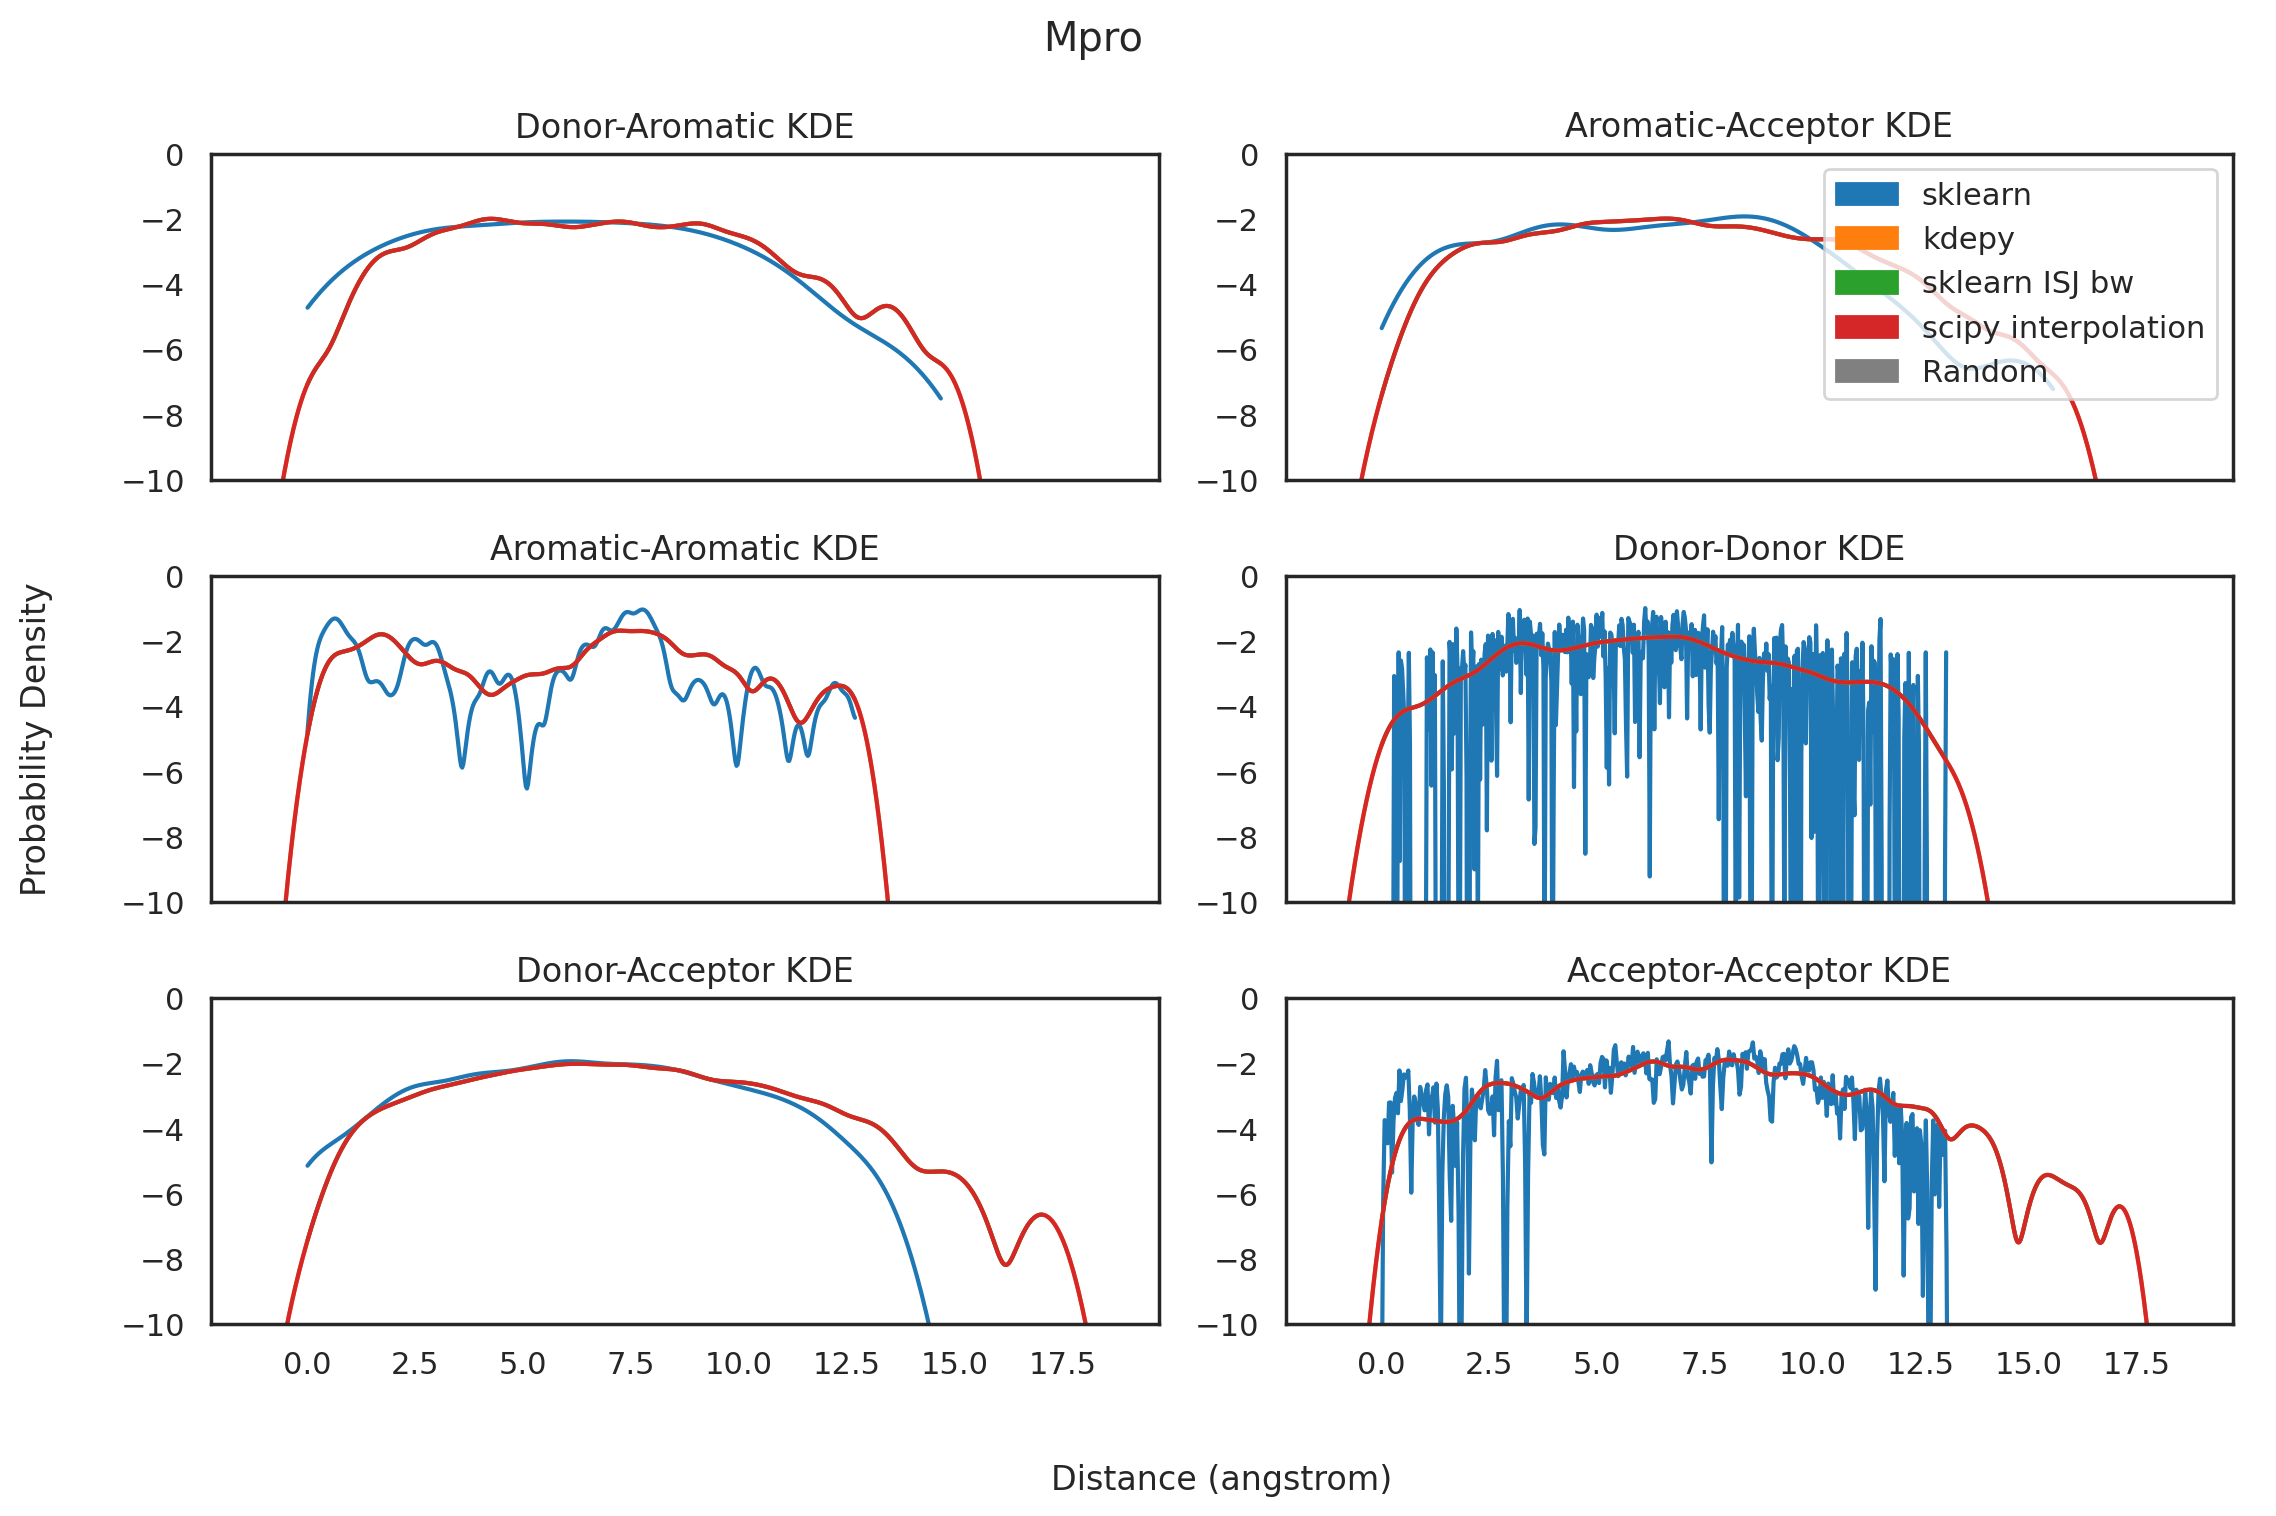

In [5]:
def plot_kdes_against_each_other_and_return_interpolation(kde_dicts, frag_2body_dict, rand_kde_dicts, name, c=0, weights=None):
    """_summary_

    Args:
        kde_dicts (_type_): _description_
        frag_2body_dict (_type_): _description_
        rand_kde_dicts (_type_): _description_
        name (_type_): _description_
        c (int, optional): _description_. Defaults to 0.
        weights (_type_, optional): _description_. Defaults to None.

    Returns:
        `scipy.interpolate.interp1d` function: returns an approximation to a KDE fit on the data with ISJ bandwidth.
    """

    n_rand = 10
    nx = 500

    fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(
        12, 8), dpi=200)
    fig.suptitle(name)

    interpolated_kdes = {}
    axs = axs.reshape(-1)

    for i, pcore_combo in enumerate(PHARMACOPHORE_COMBINATIONS):

        axs[i].set_title('{} KDE'.format(pcore_combo))

        kde_pair = kde_dicts[pcore_combo]

        x = np.linspace(0, np.amax(frag_2body_dict[pcore_combo]), nx)

        pair_dist = kde_pair.score_samples(x.reshape(-1, 1))
        pair_dist = pair_dist.flatten()

        axs[i].plot(x, pair_dist, color=CMAP(c))

        if weights is None:
            kdepy_model = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(
                frag_2body_dict[pcore_combo])
        else:
            kdepy_model = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ').fit(
                frag_2body_dict[pcore_combo], weights=weights[pcore_combo])
        kdepy_x, kdepy_y = kdepy_model.evaluate()
        kdepy_bw = kdepy_model.bw
        axs[i].plot(kdepy_x, np.log(kdepy_y), color=CMAP(c+1))

        if weights is None:
            kde_new = KernelDensity(
                kernel='gaussian', bandwidth=kdepy_bw, rtol=1e-4).fit(
                    frag_2body_dict[pcore_combo].reshape(-1, 1))
        else:
            kde_new = KernelDensity(
                kernel='gaussian', bandwidth=kdepy_bw, rtol=1e-4).fit(
                    frag_2body_dict[pcore_combo].reshape(-1, 1), sample_weight=weights[pcore_combo])

        new_dist = kde_new.score_samples(x.reshape(-1, 1))

        new_dist = new_dist.flatten()
        axs[i].plot(x, new_dist, color=CMAP(c+2))

        # use interpolated spline to speed up future scoring
        scipy_interpolation = interp1d(kdepy_x, np.log(kdepy_y), fill_value='extrapolate')
        axs[i].plot(kdepy_x, scipy_interpolation(kdepy_x), color=CMAP(c+3))
        axs[i].set_ylim(top=0, bottom=-10)

        interpolated_kdes[pcore_combo] = scipy_interpolation
        for n in range(n_rand):
            kde_rand = rand_kde_dicts[n][pcore_combo]

            rand_dist = kde_rand.score_samples(x.reshape(-1, 1))
            rand_dist = rand_dist.flatten()

            # axs[i].plot(x, rand_dist, alpha=0.2, color='grey')
    legend_elements = [Rectangle((0, 0), 1, 1, color=CMAP(c), label='sklearn'),
                       Rectangle((0, 0), 1, 1, color=CMAP(c+1), label='kdepy'),
                       Rectangle((0, 0), 1, 1, color=CMAP(
                           c+2), label='sklearn ISJ bw'),
                       Rectangle((0, 0), 1, 1, color=CMAP(
                           c+3), label='scipy interpolation'),
                       Rectangle((0, 0), 1, 1,  color='grey', label='Random')]
    axs[1].legend(handles=legend_elements, loc='upper right')
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False,
                    bottom=False, left=False, right=False)
    plt.xlabel('Distance (angstrom)', labelpad=30)
    plt.ylabel('Probability Density', labelpad=30)

    fig.tight_layout()
    fig.show()
    return fig, interpolated_kdes

fig_kdes_against_each_other, interpolated_kdes = plot_kdes_against_each_other_and_return_interpolation(kde_dict_opt, frag_pair_distance_dict, rand_kde_dicts, name='Mpro', c=0)
fig_kdes_against_each_other.savefig(f'{fig_dir}/kdes_against_each_other.png')
